In [1]:
import random

import flax
import flax.linen as nn
import jax
import jax.numpy as jnp
import numpy as np
import optax
from flax.training.train_state import TrainState
from stable_baselines3.common.buffers import ReplayBuffer

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from tqdm.auto import trange

from rl_env.myenv_redesign import MyEnv
from base_rl_mcmc.distributions import Distribution

import toml
from types import SimpleNamespace

from torch.utils.tensorboard import SummaryWriter
import time

config = toml.load("./base_rl_mcmc/config/config_ddpg.toml")
args = SimpleNamespace(**config)

# seeding
random.seed(args.seed)
np.random.seed(args.seed)
key = jax.random.PRNGKey(args.seed)
key, actor_key, qf1_key = jax.random.split(key, 3)

run_name = "ddp_mcmc_redesign"
writer = SummaryWriter(f"runs/{run_name}")

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
# Initialize Agent

class QNetwork(nn.Module):
    """
    Critic Network
    """
    @nn.compact
    def __call__(self, x: jnp.ndarray, a: jnp.ndarray):
        x = jnp.concatenate([x, a], -1)
        x = nn.Dense(36)(x)
        x = nn.softplus(x)
        x = nn.Dense(48)(x)
        x = nn.softplus(x)
        x = nn.Dense(36)(x)
        x = nn.softplus(x)
        x = nn.Dense(1)(x)
        x = nn.softplus(x)
        return x

class Actor(nn.Module):
    action_dim: int

    @nn.compact
    def __call__(self, obs: jnp.ndarray):
        obs = obs.reshape(-1, 2)
        x = obs[:, 0:1]
        eps = obs[:, 1:2]

        x_sigma = self.phi(x, name="x_sigma")
        x_1_sigma = x + eps * x_sigma
        x_1_sigma = self.phi(x_1_sigma, name="x_1_sigma")

        return jnp.concatenate([x_sigma, x_1_sigma], -1)

    def phi(self, input, name):
        x = nn.Dense(36, name=f"{name}_dense1")(input)
        x = nn.softplus(x)
        x = nn.Dense(48, name=f"{name}_dense2")(x)
        x = nn.softplus(x)
        x = nn.Dense(36, name=f"{name}_dense3")(x)
        x = nn.softplus(x)
        x = nn.Dense(self.action_dim, name=f"{name}_dense4")(x)
        x = nn.softplus(x)
        return x

In [3]:
class TrainState(TrainState):
    target_params: flax.core.FrozenDict

In [4]:
# Setup env
log_p = Distribution.gaussian1D
dim = 1
max_steps=10_000

env = MyEnv(log_p, dim, max_steps)
max_action = float(env.action_space.high[0])
env.observation_space.dtype = np.float32
rb = ReplayBuffer(
    args.buffer_size,
    env.observation_space,
    env.action_space,
    device='cpu',
    handle_timeout_termination=False,
)

In [5]:
# Start
obs, _ = env.reset()

actor = Actor(action_dim=env.dim)
qf1 = QNetwork()

actor_state = TrainState.create(
    apply_fn=actor.apply,
    params=actor.init(actor_key, obs),
    target_params=actor.init(actor_key, obs),
    tx=optax.adam(learning_rate=args.learning_rate),
)

qf1_state = TrainState.create(
    apply_fn=qf1.apply,
    params=qf1.init(qf1_key, obs, env.action_space.sample()),
    target_params=qf1.init(qf1_key, obs, env.action_space.sample()),
    tx=optax.adam(learning_rate=args.learning_rate),
)

actor.apply = jax.jit(actor.apply)
qf1.apply = jax.jit(qf1.apply)

In [6]:
@jax.jit
def update_critic(
    actor_state: TrainState,
    qf1_state: TrainState,
    observations: np.ndarray,
    actions: np.ndarray,
    next_observations: np.ndarray,
    rewards: np.ndarray,
    dones: np.ndarray,
):
    next_state_actions = (actor.apply(actor_state.target_params, next_observations)).clip(-1, 1)  # TODO: proper clip
    qf1_next_target = qf1.apply(qf1_state.target_params, next_observations, next_state_actions).reshape(-1)
    next_q_value = (rewards + (1 - dones) * args.gamma * (qf1_next_target)).reshape(-1)

    def mse_loss(params):
        qf1_a_values = qf1.apply(params, observations, actions).squeeze()
        return ((qf1_a_values - next_q_value) ** 2).mean(), qf1_a_values.mean()

    (qf1_loss_value, qf1_a_values), grads = jax.value_and_grad(mse_loss, has_aux=True)(qf1_state.params)
    qf1_state = qf1_state.apply_gradients(grads=grads)
    return qf1_state, qf1_loss_value, qf1_a_values

@jax.jit
def update_actor(
    actor_state: TrainState,
    qf1_state: TrainState,
    observations: np.ndarray,
):
    def actor_loss(params):
        return -qf1.apply(qf1_state.params, observations, actor.apply(params, observations)).mean()

    actor_loss_value, grads = jax.value_and_grad(actor_loss)(actor_state.params)
    actor_state = actor_state.apply_gradients(grads=grads)
    actor_state = actor_state.replace(
        target_params=optax.incremental_update(actor_state.params, actor_state.target_params, args.tau)
    )
    qf1_state = qf1_state.replace(
        target_params=optax.incremental_update(qf1_state.params, qf1_state.target_params, args.tau)
    )
    return actor_state, qf1_state, actor_loss_value


In [7]:
start_time = time.time()

for global_step in trange(args.total_timesteps):

    actions = actor.apply(actor_state.params, obs)
    # actions = np.asarray(actions + np.random.normal(0, args.exploration_noise)).clip(
    #             env.action_space.low, env.action_space.high)

    next_obs, rewards, terminateds, truncateds, infos = env.step(actions.flatten())

    real_next_obs = next_obs.copy()
    rb.add(obs, real_next_obs, actions, rewards, terminateds, infos)

    obs = next_obs

    # Training
    if global_step > args.learning_starts:
        data = rb.sample(args.batch_size)
        qf1_state, qf1_loss_value, qf1_a_values = update_critic(
            actor_state,
            qf1_state,
            data.observations.numpy(),
            data.actions.numpy(),
            data.next_observations.numpy(),
            data.rewards.flatten().numpy(),
            data.dones.flatten().numpy(),
        )
        if global_step % args.policy_frequency == 0:
            actor_state, qf1_state, actor_loss_value = update_actor(
                actor_state,
                qf1_state,
                data.observations.numpy(),
            )

        if global_step % 100 == 0:
            writer.add_scalar("losses/qf1_loss", qf1_loss_value.item(), global_step)
            writer.add_scalar("losses/actor_loss", actor_loss_value.item(), global_step)
            writer.add_scalar("losses/qf1_values", qf1_a_values.item(), global_step)
            print("SPS:", int(global_step / (time.time() - start_time)))
            writer.add_scalar("charts/SPS", int(global_step / (time.time() - start_time)), global_step)

  0%|          | 0/20000 [00:00<?, ?it/s]

SPS: 65
SPS: 119
SPS: 164
SPS: 203
SPS: 236
SPS: 265
SPS: 292
SPS: 315
SPS: 335
SPS: 355
SPS: 372
SPS: 388
SPS: 402
SPS: 416
SPS: 428
SPS: 439
SPS: 449
SPS: 459
SPS: 468
SPS: 477
SPS: 485
SPS: 492
SPS: 499
SPS: 506
SPS: 512
SPS: 518
SPS: 523
SPS: 529
SPS: 534
SPS: 538
SPS: 543
SPS: 547
SPS: 551
SPS: 555
SPS: 559
SPS: 563
SPS: 566
SPS: 569
SPS: 573
SPS: 575
SPS: 578
SPS: 581
SPS: 584
SPS: 586
SPS: 589
SPS: 591
SPS: 593
SPS: 595
SPS: 598
SPS: 600
SPS: 602
SPS: 604
SPS: 605
SPS: 607
SPS: 609
SPS: 611
SPS: 613
SPS: 615
SPS: 616
SPS: 618
SPS: 619
SPS: 621
SPS: 622
SPS: 623
SPS: 624
SPS: 626
SPS: 627
SPS: 628
SPS: 629
SPS: 631
SPS: 632
SPS: 633
SPS: 634
SPS: 635
SPS: 636
SPS: 637
SPS: 638
SPS: 639
SPS: 640
SPS: 641
SPS: 642
SPS: 643
SPS: 643
SPS: 644
SPS: 645
SPS: 646
SPS: 647
SPS: 648
SPS: 648
SPS: 649
SPS: 650
SPS: 651
SPS: 651
SPS: 652
SPS: 653
SPS: 653
SPS: 653
SPS: 654
SPS: 654
SPS: 655
SPS: 655
SPS: 656
SPS: 656
SPS: 657
SPS: 657
SPS: 658
SPS: 658
SPS: 659
SPS: 659
SPS: 660
SPS: 660
SP

In [8]:
state_list = np.array([i for i in env.store_state])[:, 0]
action_list = np.array([i.squeeze() for i in env.store_action])
reward_list = np.array([i for i in env.store_reward]).flatten()

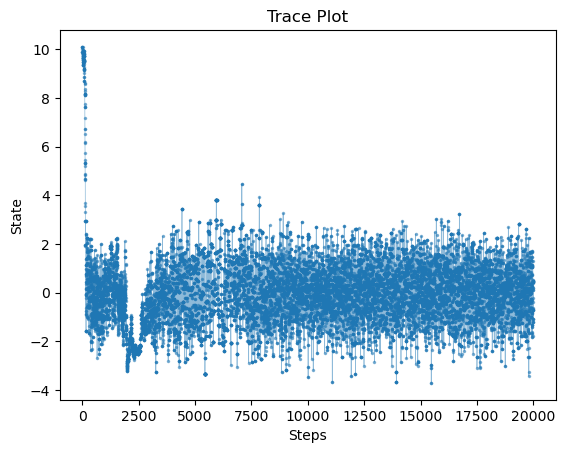

In [9]:
# Trace Plot
plt.plot(state_list, 'o-', linewidth=0.5, markersize=1.5, alpha=0.5)
plt.title("Trace Plot")
plt.xlabel("Steps")
plt.ylabel("State")
plt.show()

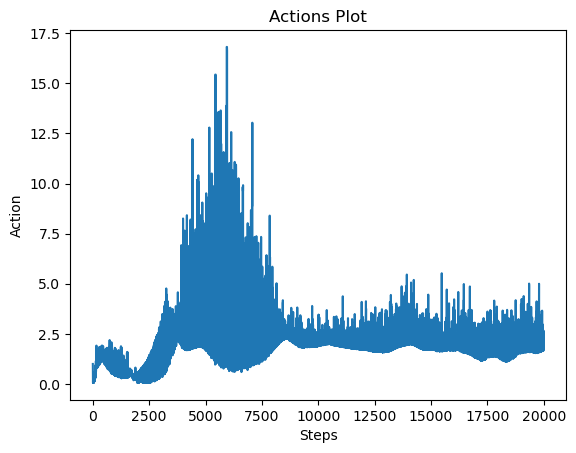

In [10]:
# Action Plot
plt.plot([i.squeeze() for i in env.store_action])
plt.title("Actions Plot")
plt.xlabel("Steps")
plt.ylabel("Action")
plt.show()

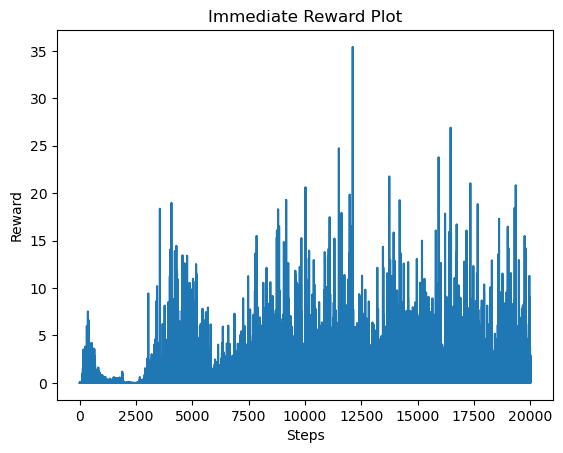

In [11]:
# Immediate Reward Plot
reward_list = np.array([i for i in env.store_reward]).flatten()
plt.plot(reward_list)
plt.title("Immediate Reward Plot")
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.show()

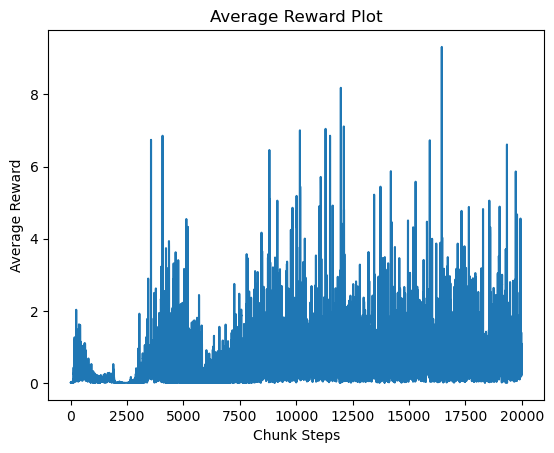

In [12]:
# Average Reward Plot
kernel = np.ones(5) / 5
averages = np.convolve(reward_list, kernel, mode='valid')

plt.plot(averages)
plt.title('Average Reward Plot')
plt.xlabel('Chunk Steps')
plt.ylabel('Average Reward')
plt.show()


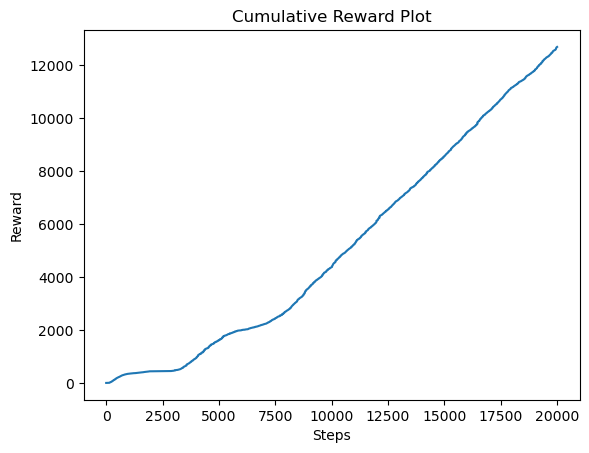

In [13]:
# Cumulative Reward Plot
plt.plot(np.cumsum(reward_list))
plt.title("Cumulative Reward Plot")
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.show()

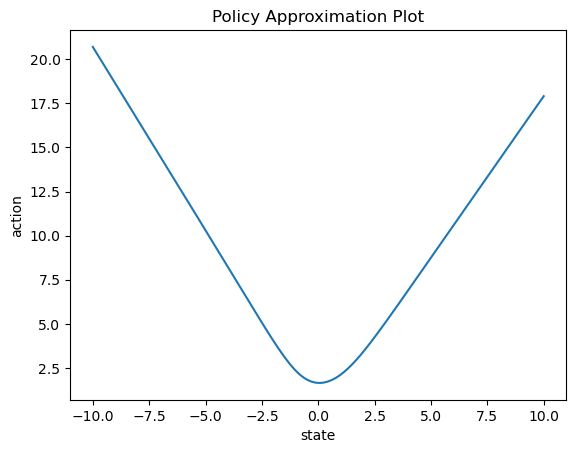

In [14]:
# Policy Plot
x = np.linspace(-10, 10, 1000)
eps = np.repeat(0.0, 1000)
obs = np.stack([x, eps], -1)
policy_action = actor.apply(actor_state.params, obs)
plt.plot(x, policy_action[:,0])

plt.title('Policy Approximation Plot')
plt.xlabel('state')
plt.ylabel('action')

plt.show()

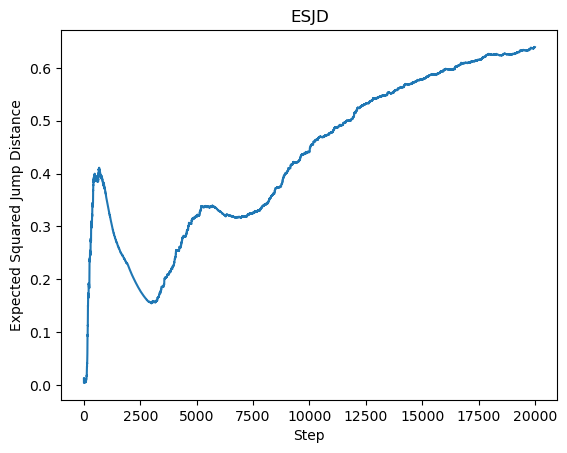

In [15]:
# ESJD Plot (Monte Carlo)
differences = np.diff(state_list.reshape(-1,1), axis=0)
squared_jump_distances = np.sum(differences**2, axis=1)
cumulative_avg_squared_jump_distances = np.cumsum(squared_jump_distances) / (np.arange(args.total_timesteps) + 1)

plt.plot(range(args.total_timesteps), cumulative_avg_squared_jump_distances)
plt.xlabel('Step')
plt.ylabel('Expected Squared Jump Distance')
plt.title('ESJD')
plt.show()